# Load Data

In [1]:
from pathlib import Path
import sys

# Go up one folder from the current notebook directory
sys.path.append(str(Path().resolve().parent))

from src.data_access import load_housing_data

In [2]:
train, test = load_housing_data()

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# EDA

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
train_eda = train.copy()

- 1460 instances, 80 features
- data types: mostly int64 and object (text, since loaded from csv), and some float64

In [20]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [50]:
X_train = train_eda.drop(columns='SalePrice')
y_train = train_eda['SalePrice']

# Classification of features
Given the large number of features (≈80), I will begin by organizing them into meaningful categories such as nominal, ordinal, skewed, constant, temporal (e.g., years), and others. This classification serves two purposes: it streamlines the EDA process by allowing focused analysis within each group, and it provides a structured foundation for building preprocessing pipelines later on.

My approach would be to mainly write categorization functions, pass the dataframe through them to get candidate sets, and then inspect each group afterward and make manual overrides.

## Numerical Features

We will begin with numerical features, dividing them into three mutually exclusive categories:

- **Continuous** (includes high-cardinality discrete variables): values span a broad range and are treated as measurable quantities. These often require scaling/normalization and may be analyzed for skewness or transformed (e.g., log, Box–Cox).

- **Ordinal**: values have a natural order but unequal or undefined spacing (e.g., quality ratings). These should be encoded with respect to rank (e.g., ordinal encoding), not treated as continuous.

- **Nominal** (numeric disguise): categorical variables stored as numbers (e.g., zip codes, IDs, codes). These require categorical encodings (e.g., one-hot or target encoding) rather than numeric operations.

In addition, overlapping sub-categories such as the following may be defined:

- **Temporal** (e.g., years, months): technically numeric but typically treated as ordered categories or decomposed into features (e.g., age, time since). These are often used to engineer new features rather than modeled directly.

In [59]:
def quick_audit(df, target="SalePrice"):
    s = df.nunique().rename("nunique")
    miss = df.isna().mean().rename("na_rate")
    zero = (df == 0).mean(numeric_only=True).rename("zero_rate")
    out = pd.concat([s, miss, zero], axis=1)
    out['dtype'] = df.dtypes
    if target in df:
        out["corr_num"] = df.select_dtypes("number").corr()[target]
    return out.sort_values(["nunique"], ascending=False)

In [61]:
num_audit = quick_audit(train_eda.select_dtypes(include='number'))
num_audit

,nunique,na_rate,zero_rate,dtype,corr_num
Id,1460,0.000000,0.000000,int64,-0.021917
LotArea,1073,0.000000,0.000000,int64,0.263843
GrLivArea,861,0.000000,0.000000,int64,0.708624
BsmtUnfSF,780,0.000000,0.080822,int64,0.214479
1stFlrSF,753,0.000000,0.000000,int64,0.605852
TotalBsmtSF,721,0.000000,0.025342,int64,0.613581
SalePrice,663,0.000000,0.000000,int64,1.000000
BsmtFinSF1,637,0.000000,0.319863,int64,0.386420
GarageArea,441,0.000000,0.055479,int64,0.623431
2ndFlrSF,417,0.000000,0.567808,int64,0.319334


It can be observed that features naturally divide into two broad groups based on cardinality: those with more than ~25 unique values and those with fewer. Features with high cardinality are more likely to be continuous (or discrete with a wide range), whereas those with low cardinality may represent categorical information. Importantly, within the low-cardinality group, some features that appear numeric may in fact be nominal categories encoded as numbers (e.g., codes, labels). These should be carefully identified and reclassified before analysis and modeling.

In [64]:
low_card_num_cols = num_audit[num_audit['nunique'] < 25].index.tolist()
high_card_num_cols = [c for c in num_audit.index if c not in low_card_num_cols]

### Low Cardinality Numerical Features

To this end, I define a function that visualizes the relationship between each low-cardinality feature and the target variable. The idea is twofold: (i) to inspect the distribution of categories in greater detail (counts, variability), and (ii) to examine how the target behaves across those categories. If a variable is truly ordinal, we should expect to see a monotonic or step-wise trend in the target means across categories. Conversely, if no meaningful order emerges, the feature is likely nominal and should be treated as such.

At the same time, these plots naturally lend themselves to broader classification decisions. Specifically, they make it easier to:

- Identify zero-heavy features that can be collapsed into binary indicators.

- Spot rare or unstable categories that should be combined into broader bins.

- Flag imbalanced features dominated by a single category.

Thus, while the initial focus is on nominal vs. ordinal classification, this step also serves as a practical entry point into more nuanced preprocessing decisions.

In [71]:
def plot_target_by_category(df, col, target='SalePrice'):
    
    agg = (df.groupby(col)[target]
             .agg(['mean','count','std'])
             .rename(columns={'mean':'target_mean'}))
    ax = agg['target_mean'].plot(kind='bar', figsize=(6,4))

    # annotate counts on top of bars
    for i, (val, n) in enumerate(zip(agg['target_mean'], agg['count'])):
        ax.text(i, val, f'n={n}', ha='center', va='bottom', fontsize=8, rotation=0)

    ax.set_title(f'{col} vs {target} (mean)')
    ax.set_ylabel(target)
    plt.tight_layout()
    plt.show()

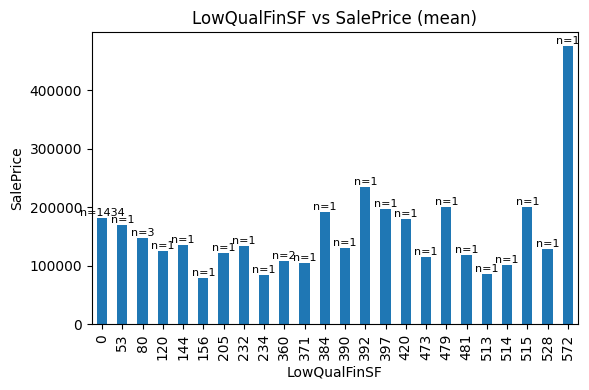

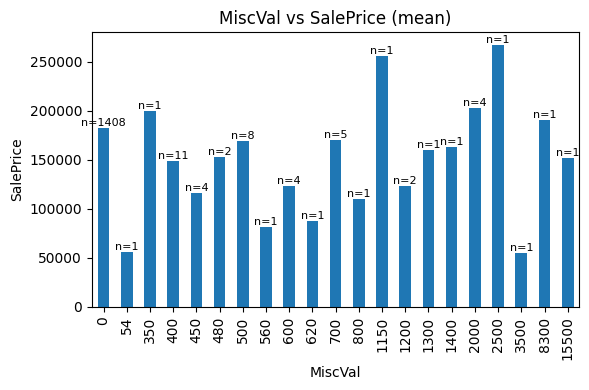

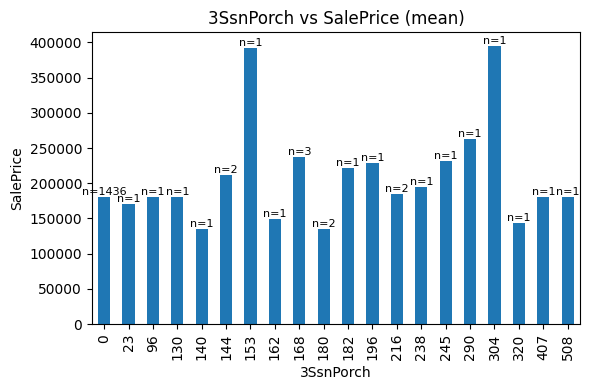

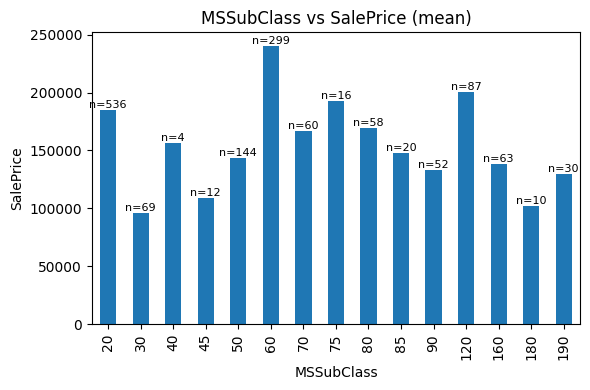

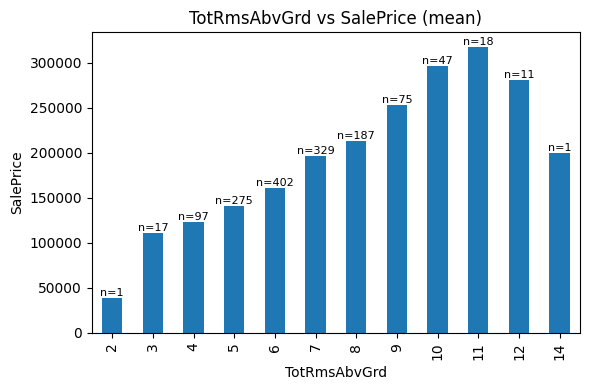

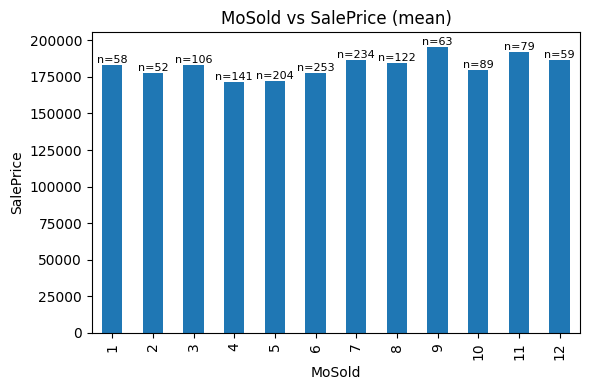

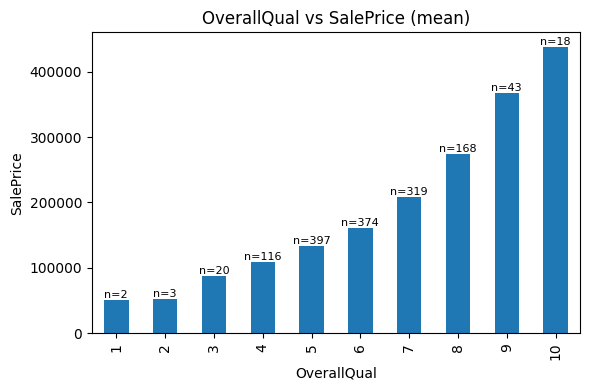

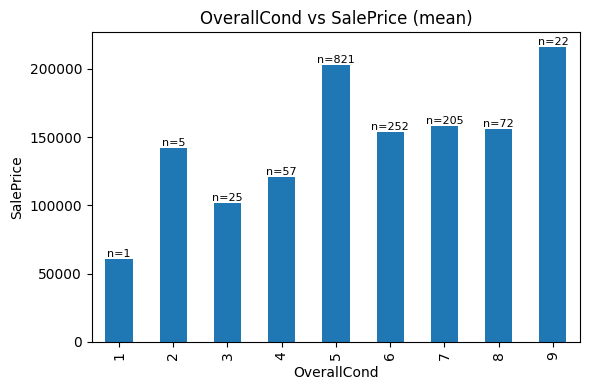

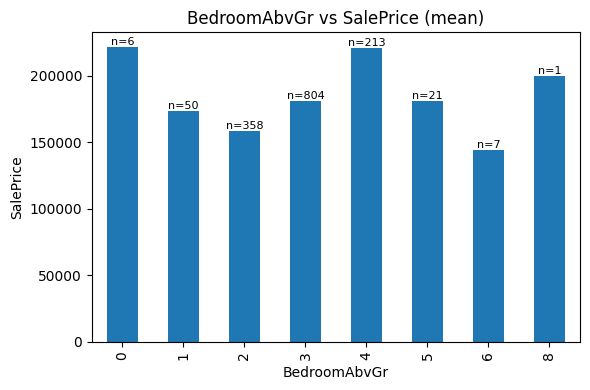

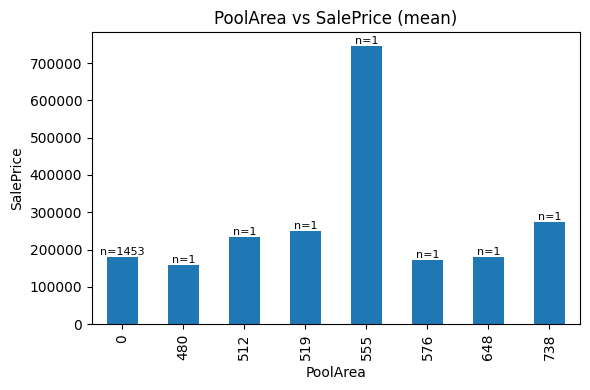

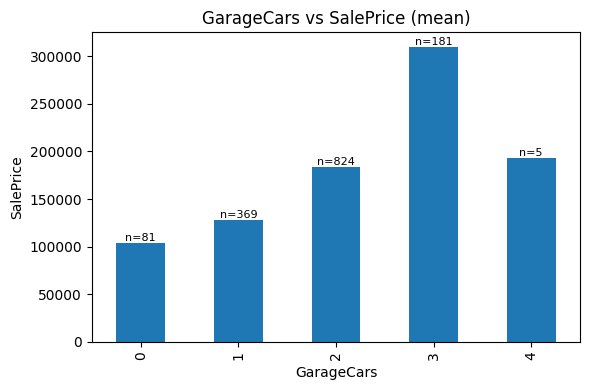

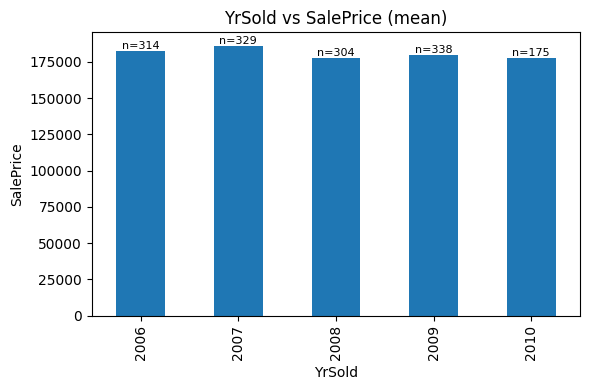

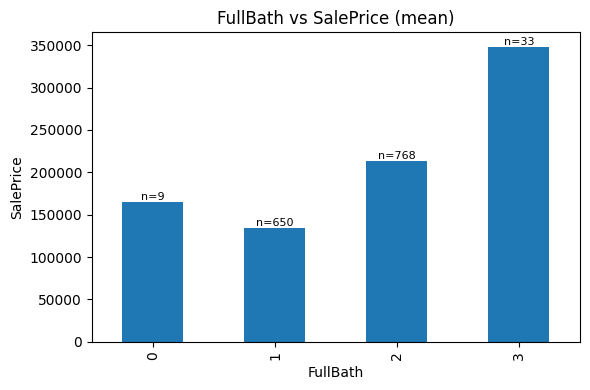

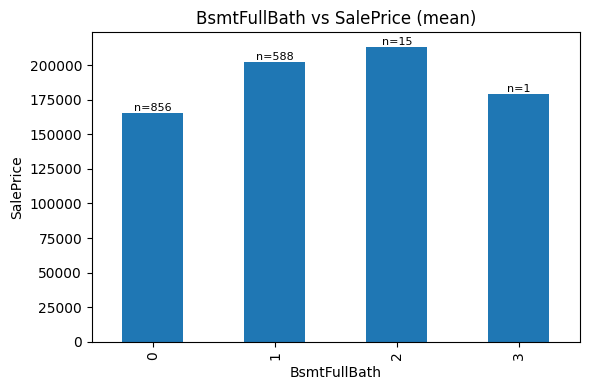

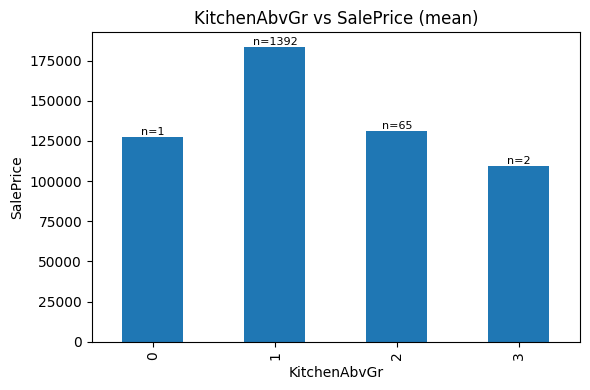

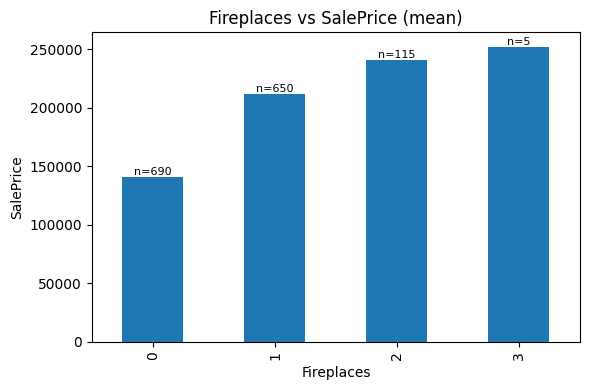

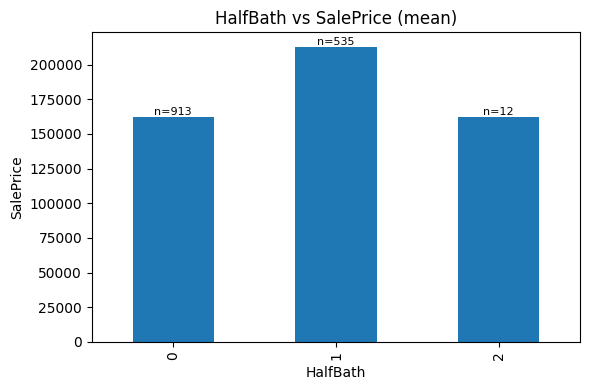

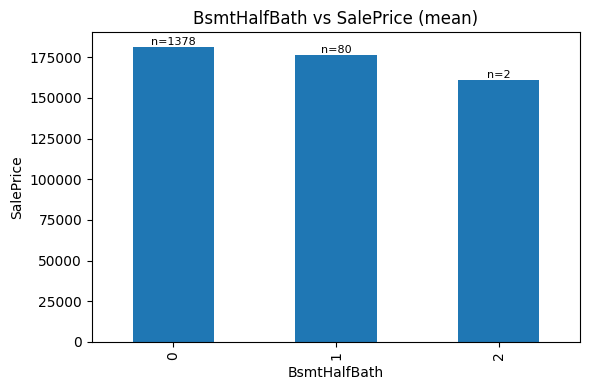

In [66]:
for col in low_card_num_cols:
    plot_target_by_category(train_eda, col)
    plt.show()

In [70]:
collapse_to_binary_cols = ['LowQualFinSF', 'MiscVal', '3SsnPorch', 'PoolArea', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath']
nominal_cols = ['MSSubClass', 'MoSold']
imabalanced = {
    'KitchenAbvGr': 'collapse to multiple kitches flag.',
    'TotRmsAbvGrd': 'join 2 and 3, and 10, 11, 12, 14',
    'OverallCond': 'collapsed into poor average good',
    'BedroomAbvGr': 'Collapse to 3 bins (Small / Typical / Large) OR drop in favor of TotRmsAbvGrd.',
    'GarageCars': 'collapse 4 into 3'
}

In [73]:
#None of the low_card_num_cols have any null entries.
num_audit.loc[low_card_num_cols]

,nunique,na_rate,zero_rate,dtype,corr_num
LowQualFinSF,24,0.0,0.982192,int64,-0.025606
MiscVal,21,0.0,0.964384,int64,-0.021190
3SsnPorch,20,0.0,0.983562,int64,0.044584
MSSubClass,15,0.0,0.000000,int64,-0.084284
TotRmsAbvGrd,12,0.0,0.000000,int64,0.533723
MoSold,12,0.0,0.000000,int64,0.046432
OverallQual,10,0.0,0.000000,int64,0.790982
OverallCond,9,0.0,0.000000,int64,-0.077856
BedroomAbvGr,8,0.0,0.004110,int64,0.168213
PoolArea,8,0.0,0.995205,int64,0.092404


### High Cardinality Numerical Features

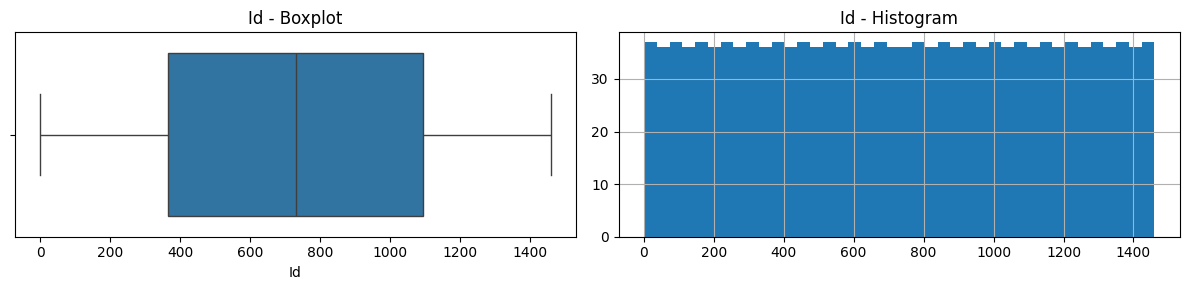

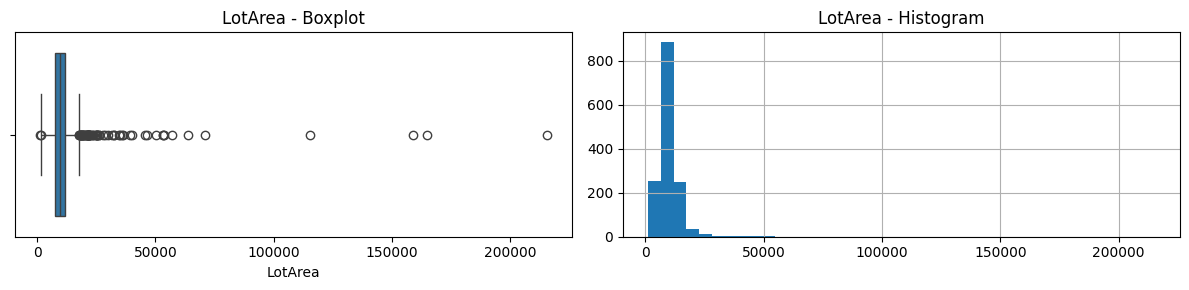

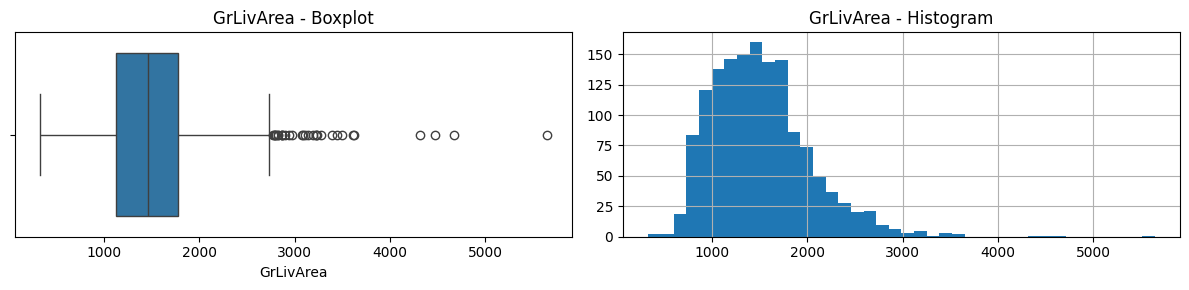

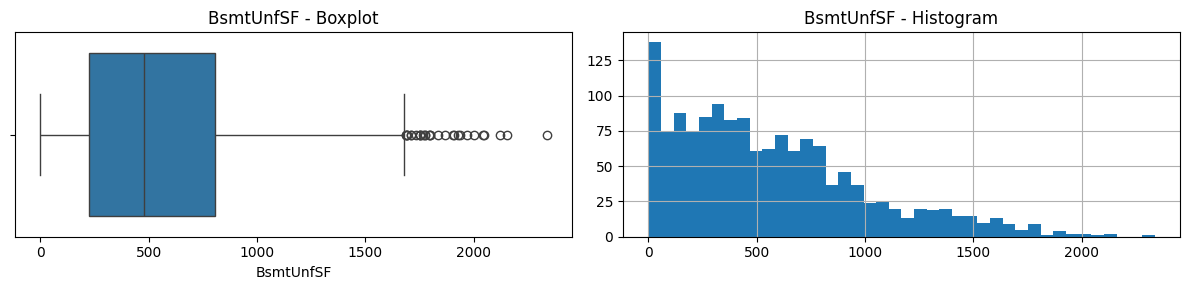

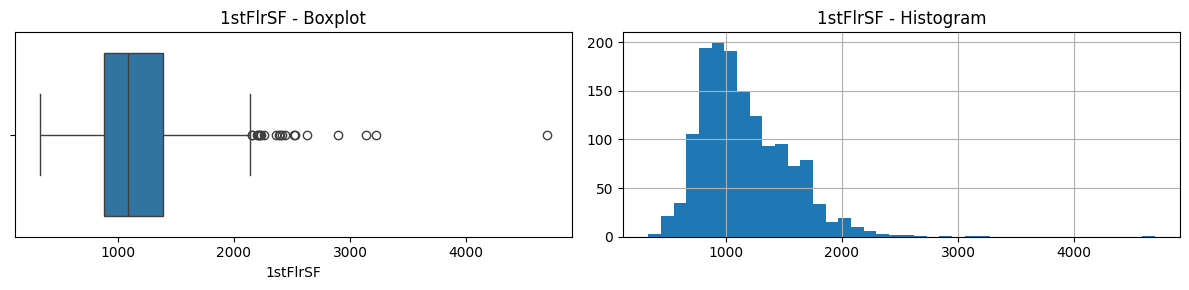

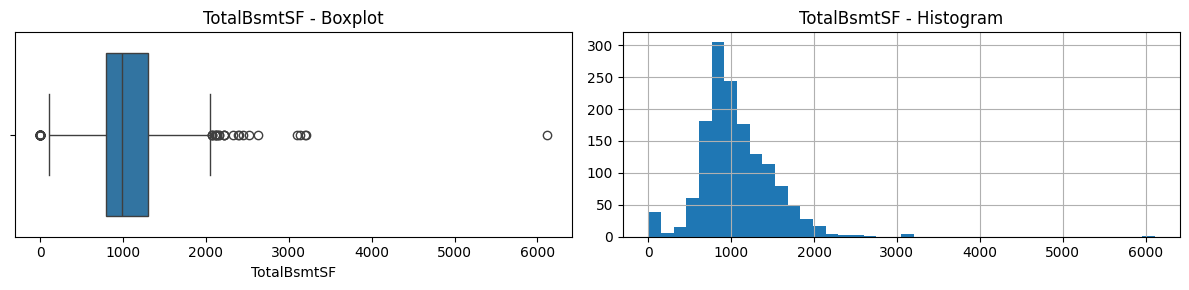

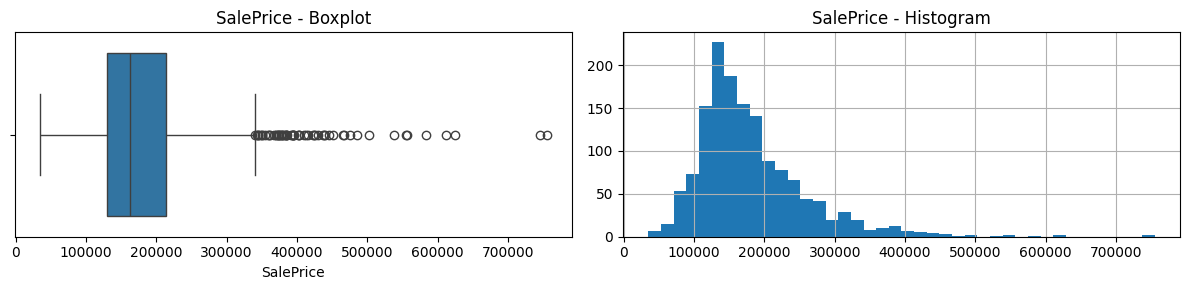

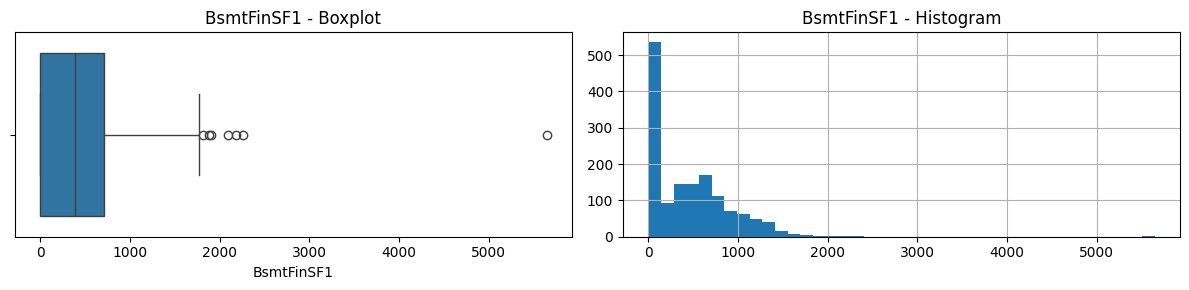

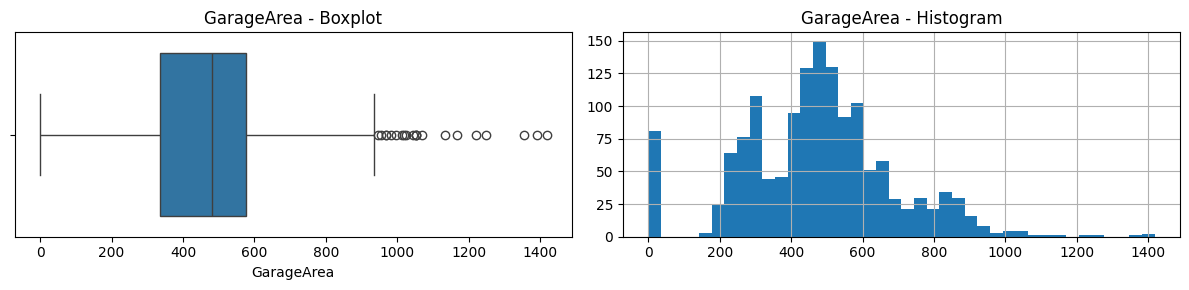

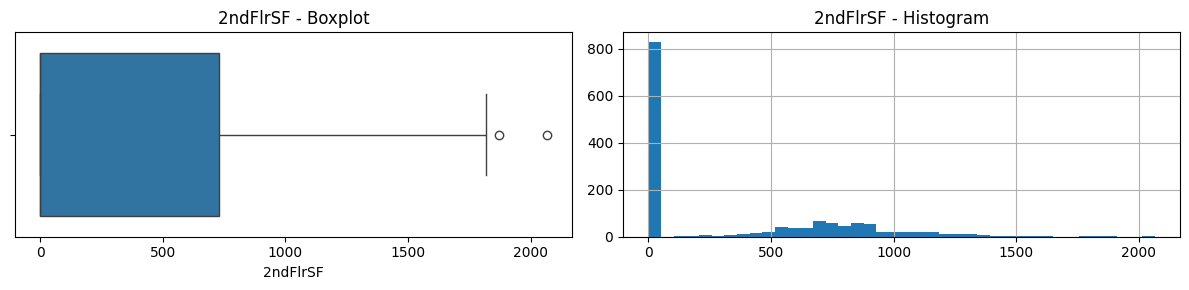

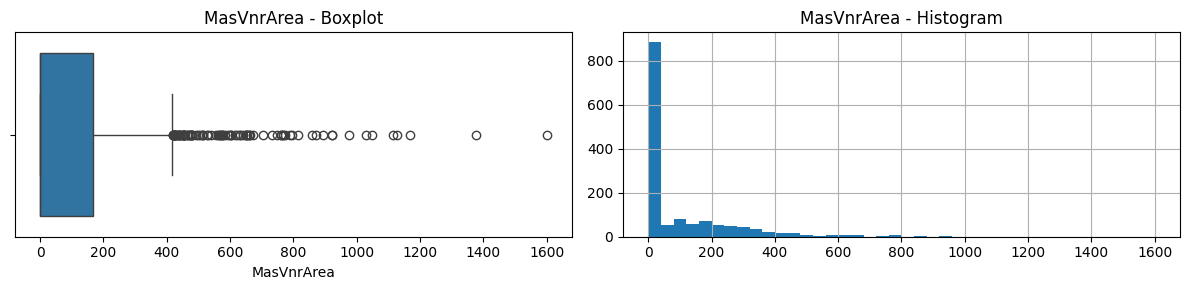

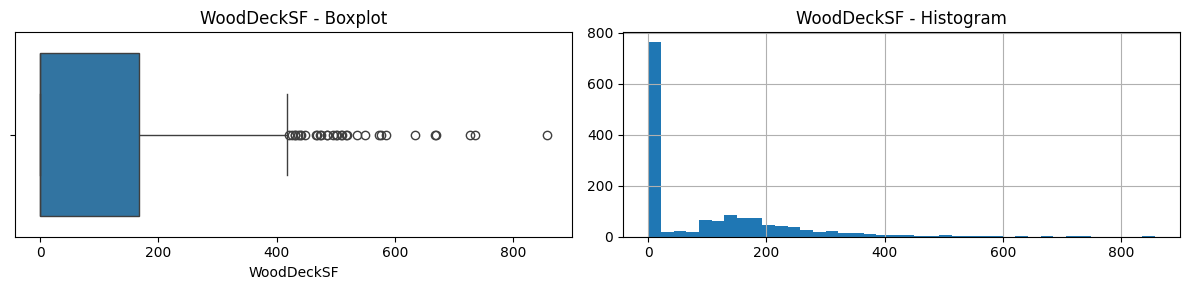

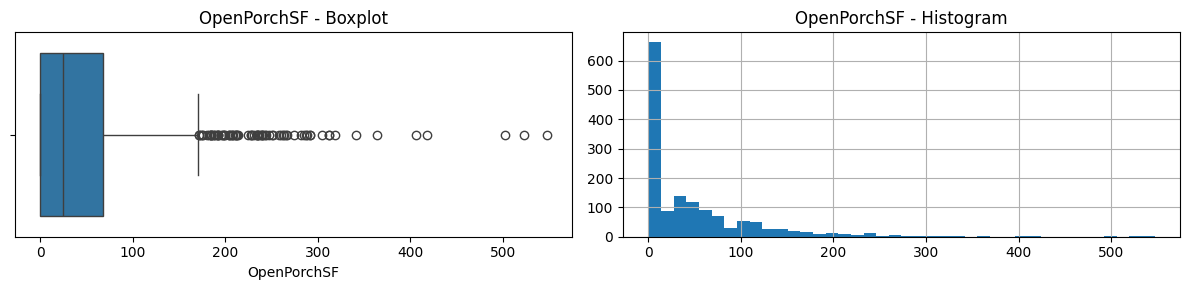

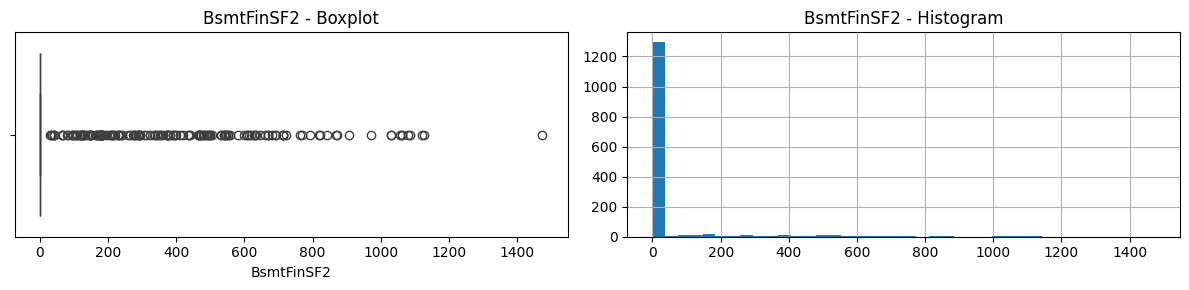

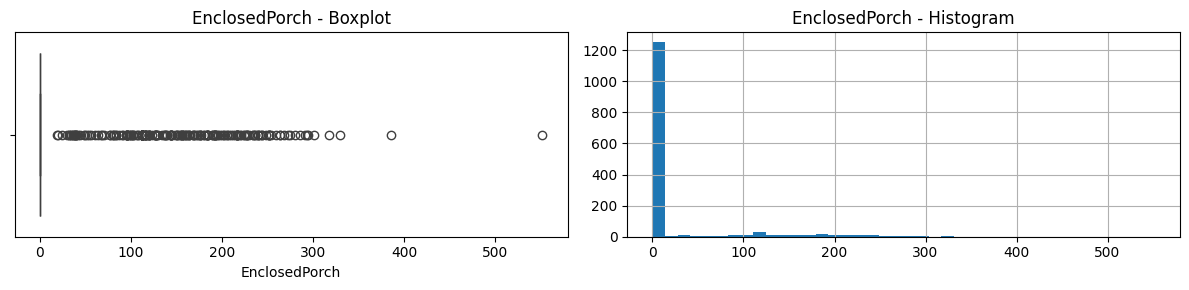

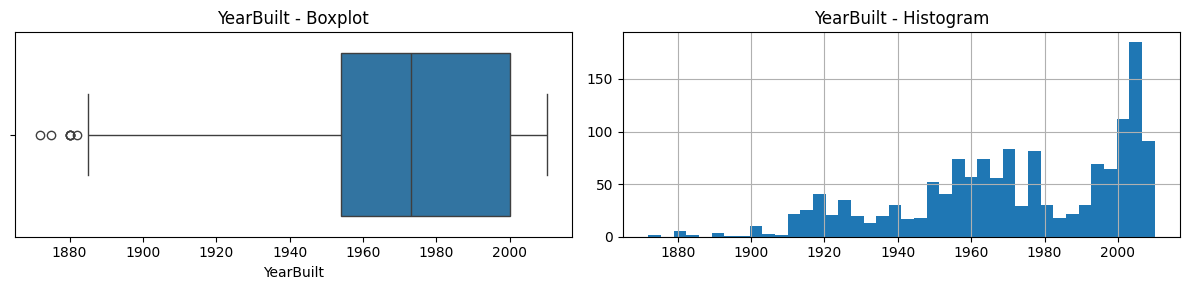

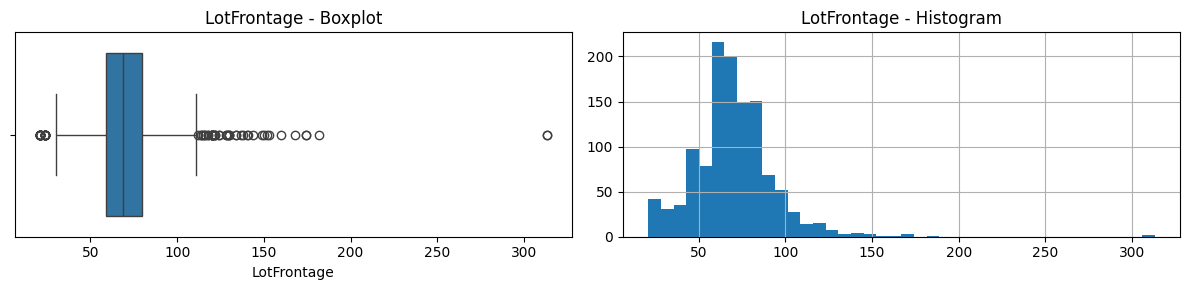

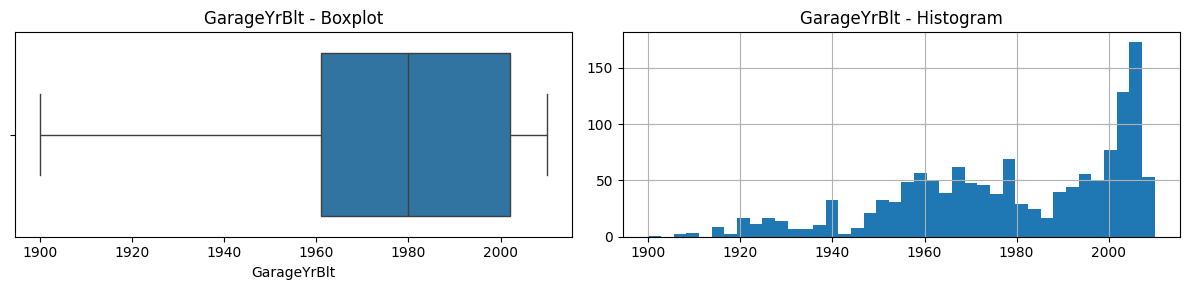

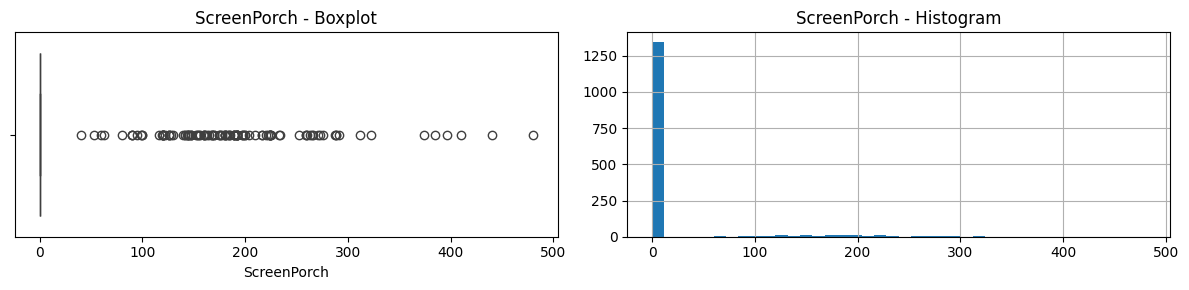

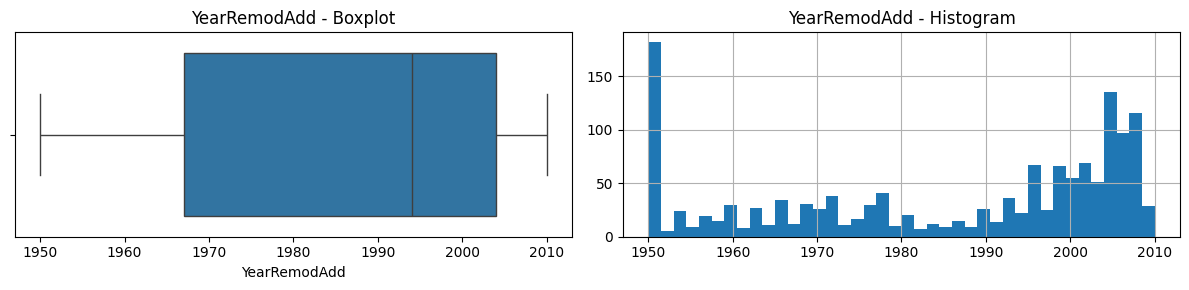

In [77]:
for col in high_card_num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    
    # Boxplot
    sns.boxplot(x=train_eda[col], ax=axes[0])
    axes[0].set_title(f"{col} - Boxplot")
    
    # Histogram
    train_eda[col].hist(bins=40, ax=axes[1])
    axes[1].set_title(f"{col} - Histogram")
    
    plt.tight_layout()
    plt.show()


In [79]:
# Continuous numeric features with strong right skew and outliers. Typically benefit from log/Box-Cox transforms.
right_skewed_cols = ['LotArea', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', 'TotalBsmtSF', 'SalePrice', 'smtFinSF1', 'GarageArea', '1stFlrSF', 'TotalBsmtSF']

#Sparse features with >90% zeros. Best simplified to binary flags (has/doesn't have) rather than kept as continuous.
collapse_to_binary_cols  += ['BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch']

# Zero-inflated but with meaningful nonzero spread. Should be treated as continuous (possibly log-transformed) plus an added binary flag.
skewed_and_binary = ['2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF', 'MasVnrArea']

In [80]:
train_eda[high_card_num_cols].skew().sort_values(ascending=False)

LotArea          12.207688
BsmtFinSF2        4.255261
ScreenPorch       4.122214
EnclosedPorch     3.089872
MasVnrArea        2.669084
OpenPorchSF       2.364342
LotFrontage       2.163569
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
GarageArea        0.179981
Id                0.000000
YearRemodAdd     -0.503562
YearBuilt        -0.613461
GarageYrBlt      -0.649415
dtype: float64

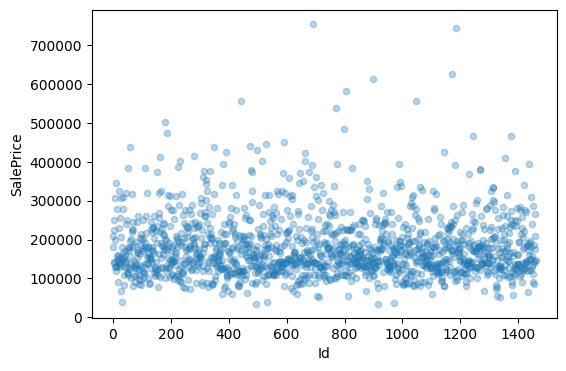

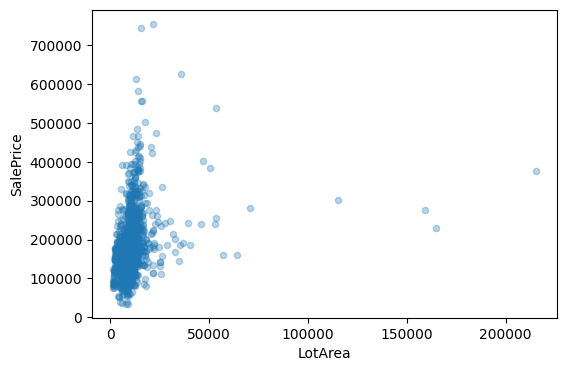

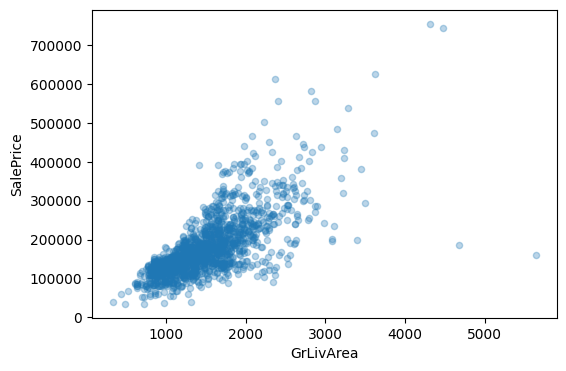

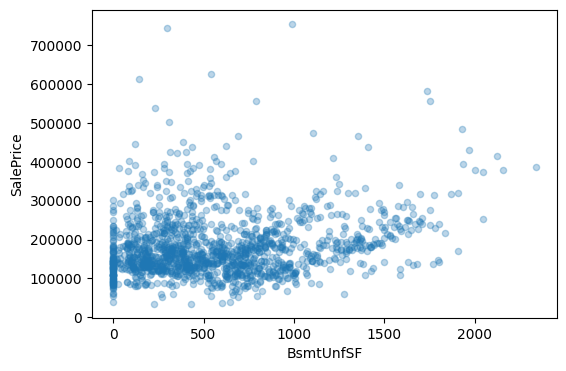

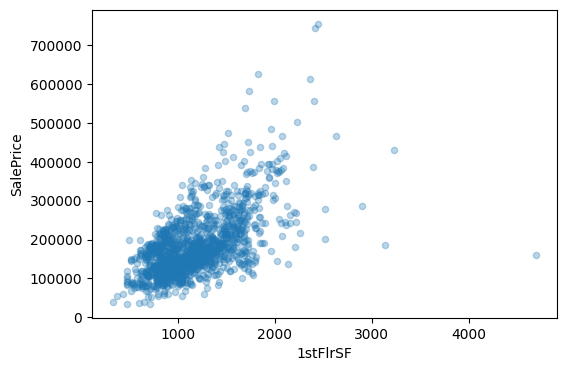

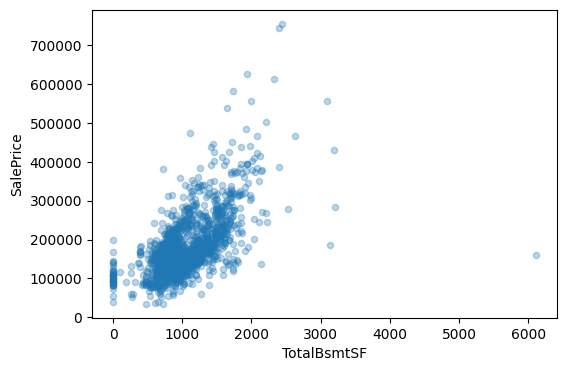

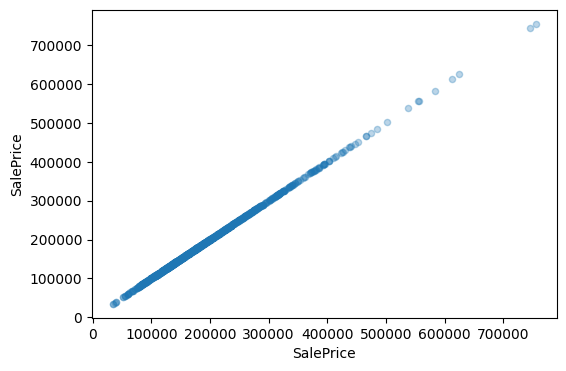

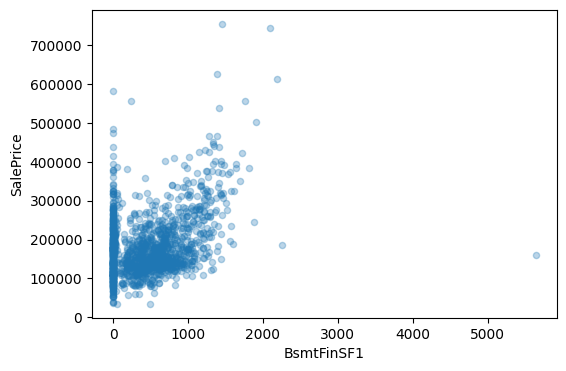

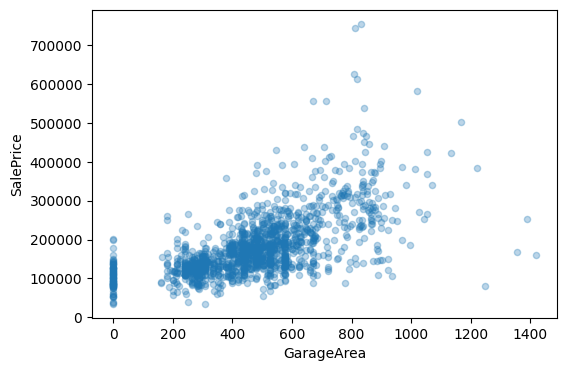

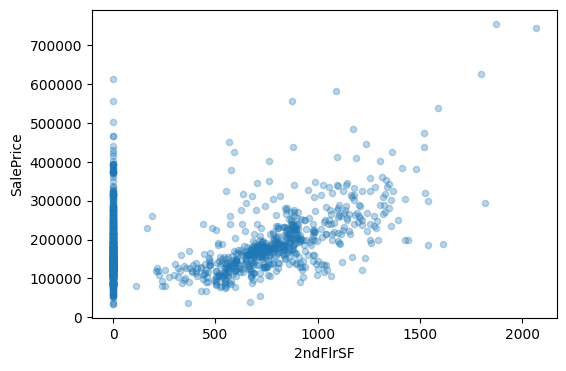

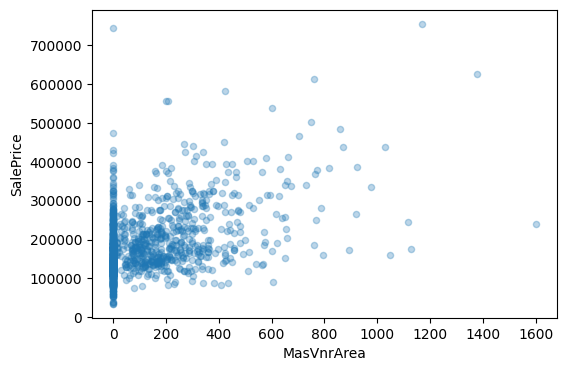

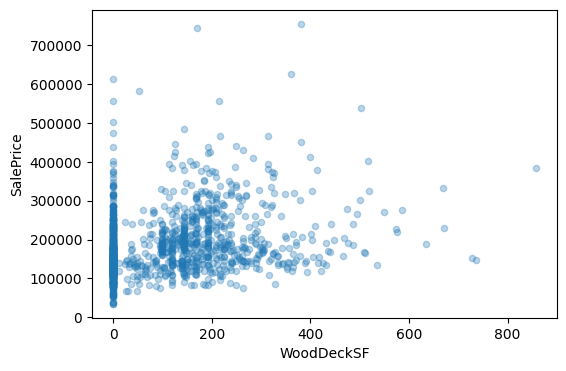

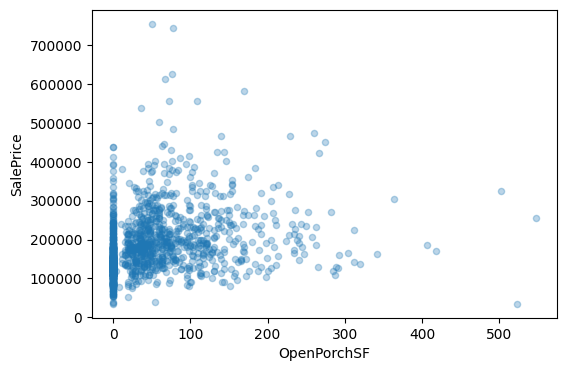

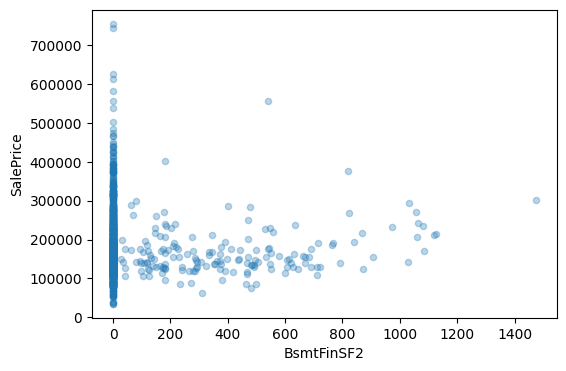

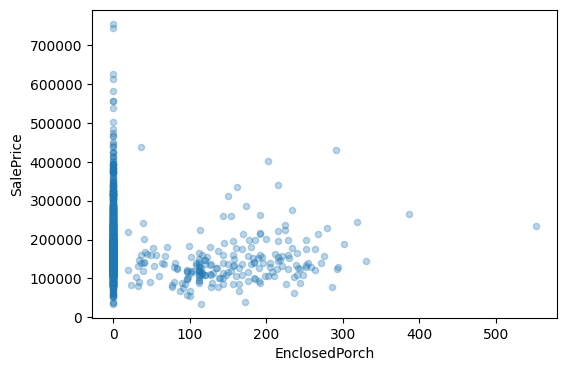

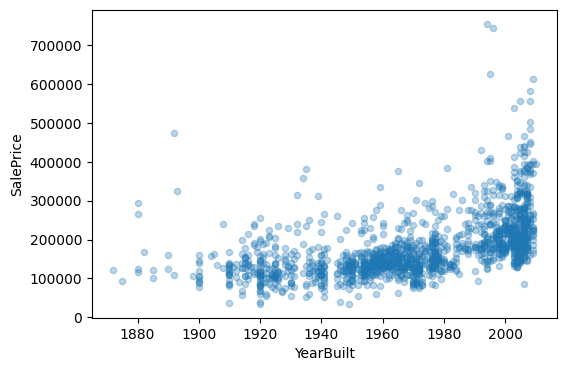

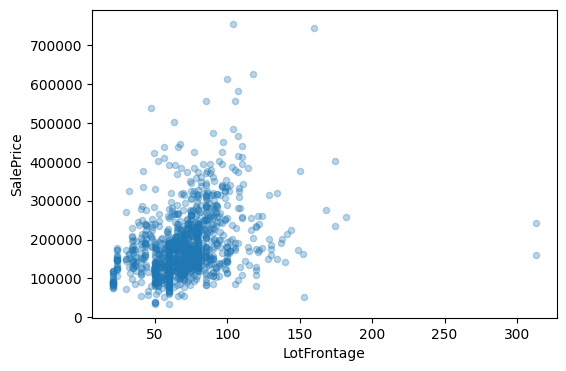

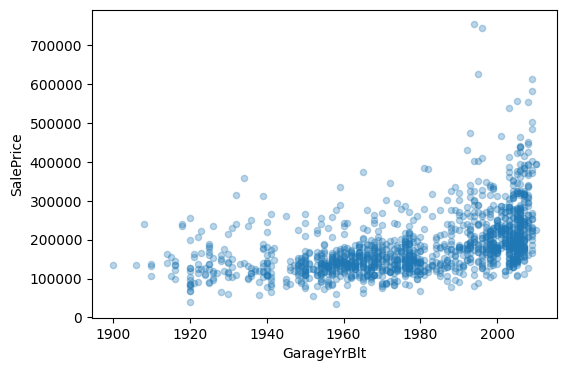

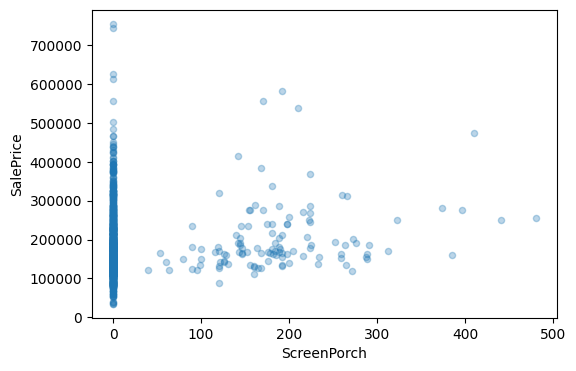

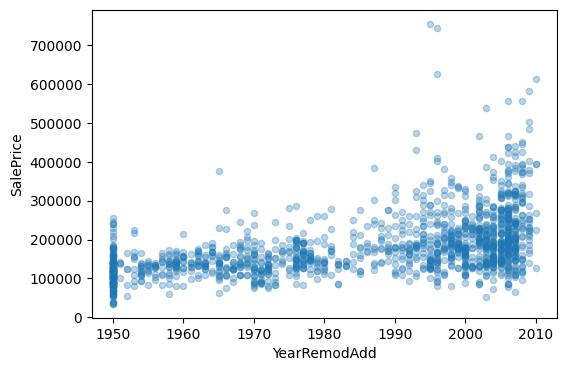

In [81]:
for col in high_card_num_cols:
    train_eda.plot.scatter(x=col, y="SalePrice", alpha=0.3, figsize=(6,4))

## Object Features

For features of object datatype, the main task is to classify them as ordinal or nominal. However, additional categorizations may also be applied as they become relevant for modeling.

In [83]:
obj_audit = quick_audit(train_eda.select_dtypes(include='object'))
obj_audit

,nunique,na_rate,zero_rate,dtype
Neighborhood,25,0.000000,0.0,object
Exterior2nd,16,0.000000,0.0,object
Exterior1st,15,0.000000,0.0,object
Condition1,9,0.000000,0.0,object
SaleType,9,0.000000,0.0,object
HouseStyle,8,0.000000,0.0,object
RoofMatl,8,0.000000,0.0,object
Condition2,8,0.000000,0.0,object
Functional,7,0.000000,0.0,object
BsmtFinType2,6,0.026027,0.0,object


In [84]:
# Some features refer to quality, while some refer to type. The former is suggests a nominal data type, while the latter ordinal. lets inspect further
qual_cols = [c for c in train_eda.select_dtypes(include='object').columns if 
             any(x in c.lower() for x in ['condition', 'cond', 'qual', 'qc', 'qu', ])]
type_cols = [c for c in train_eda.select_dtypes(include='object').columns if 'type' in c.lower()]

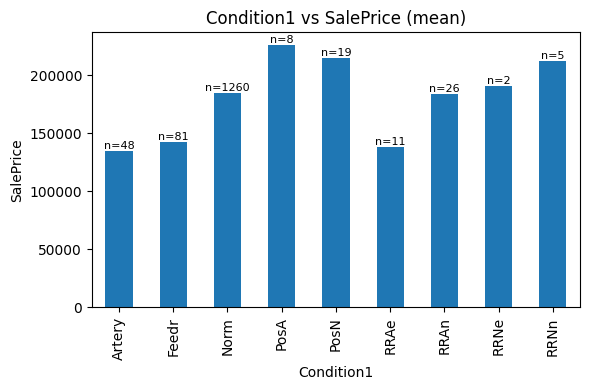

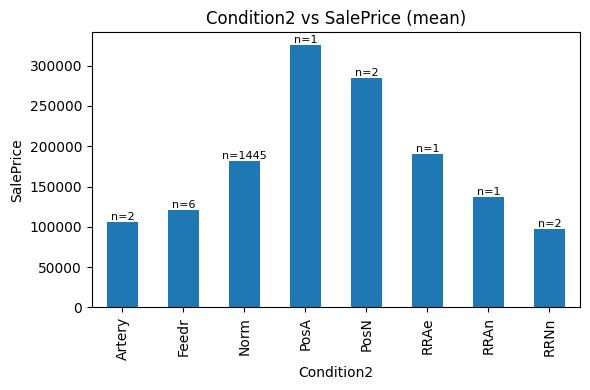

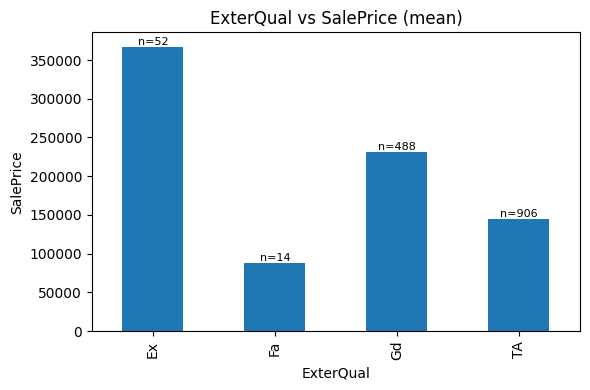

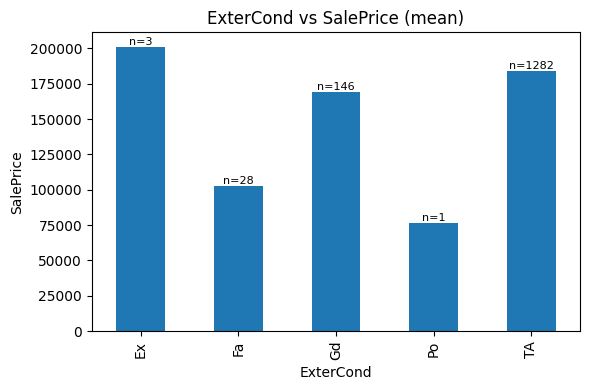

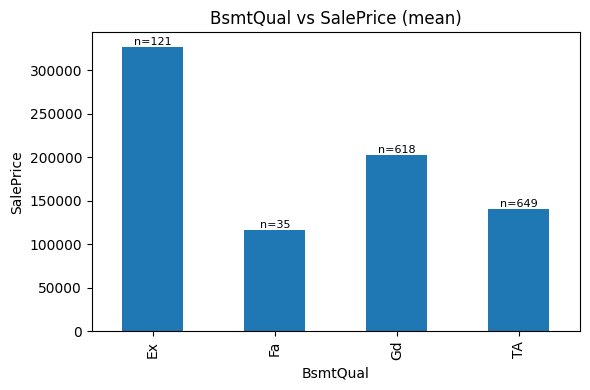

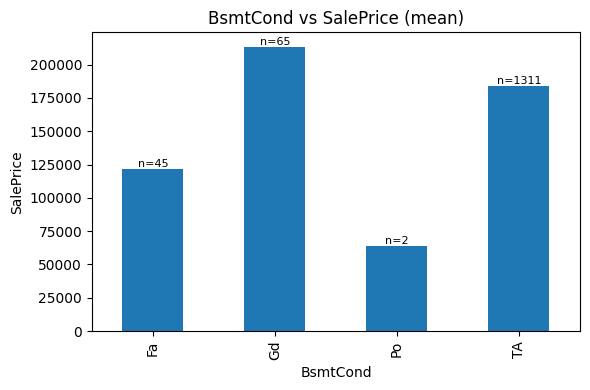

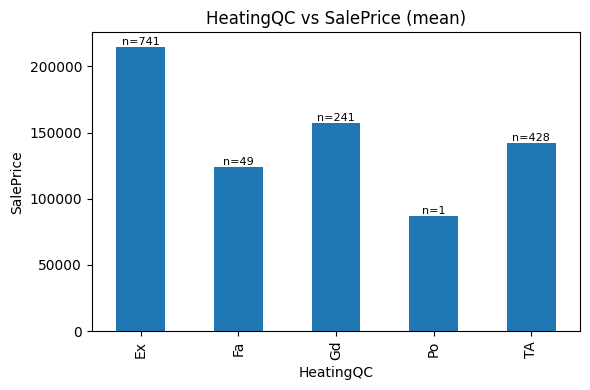

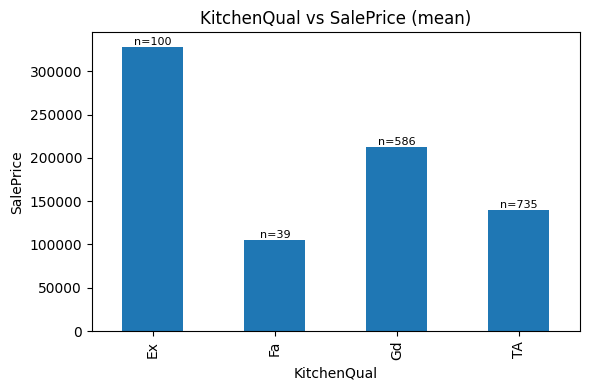

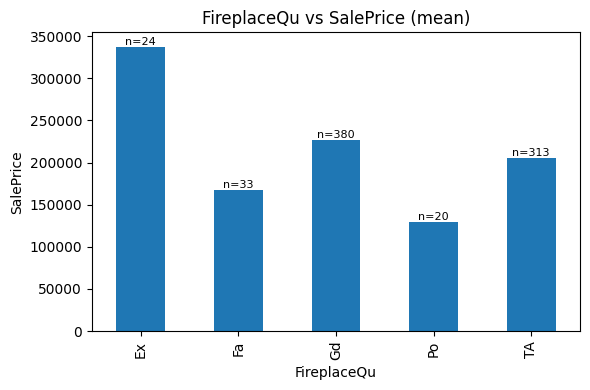

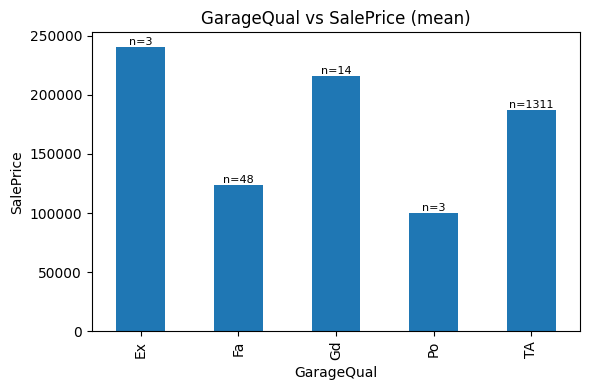

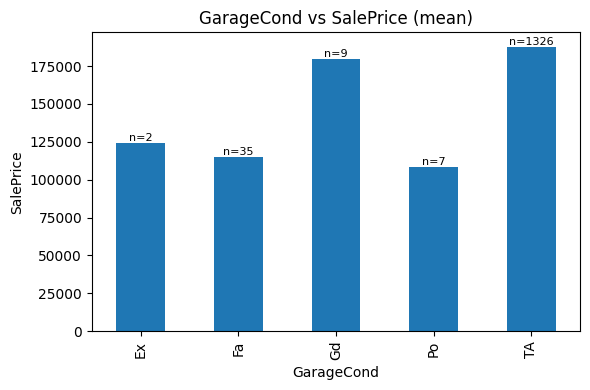

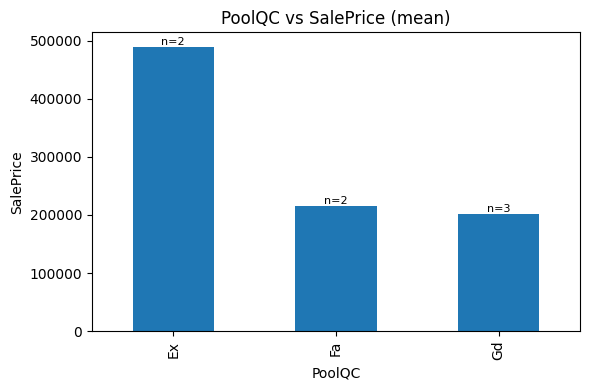

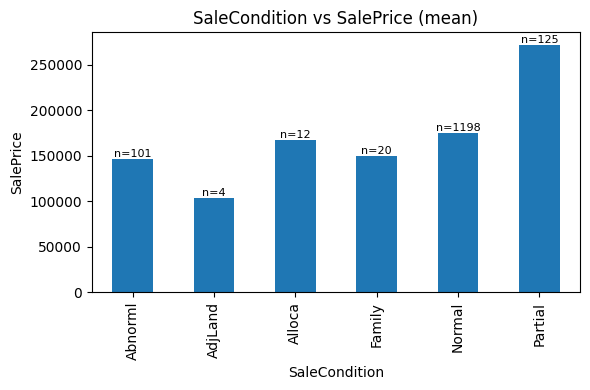

In [87]:
#To verify, lets prlot each category against the target. This will give us more information about the distribution and the behavior.
for col in qual_cols:
    plot_target_by_category(train_eda, col)

In [91]:
#It seems that the three columns with 'Condition' in their name are nominal, but the rest are ordinal
qual_cols = [x for x in qual_cols if 'condition' not in x.lower()]
qual_map = {
    "Ex": 5,
    "Gd": 4,
    "TA": 3,
    "Fa": 2,
    "Po": 1
}

In [98]:
#other insights
imbalanced_object = {
    'Condition1': 'Collapse very rare categories (<= 5 obs) into "other"',
    'Condition2': 'Collapse into "Norm" vs "Other"',
    'SaleCondition': 'collapse Adjland, alloca, and family into other',
    'GarageType': 'collapse less than 10 into other',
    'SaleType': 'Collapse less than 10 into other',
    'Exterior2nd':'combine less than and combine Wd Sdng and Wd Shng',
    'Exterior1st': 'combine less than and combine Wd Sdng and Wd Shng',
    'RoofMatl': 'collapse into other all except CompShg and WdShngl',
    'RoofStyle': 'keep Gambrel and Hip, collapse others into other',
    'heating': 'keep GasA and GasW, collapse others into other',
    'Foundation': 'collapse stone and wood into others',
    'Electrical': 'collapse FusP and Mix',
}

drop = ['PoolQC', 'MiscFeature', 'Utilities']

collapse_to_binary_cols += ['Fence', 'Alley']

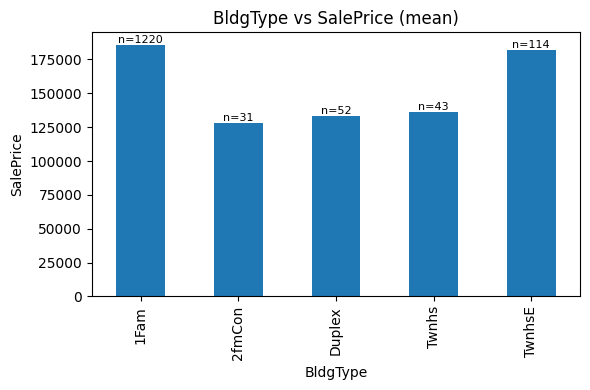

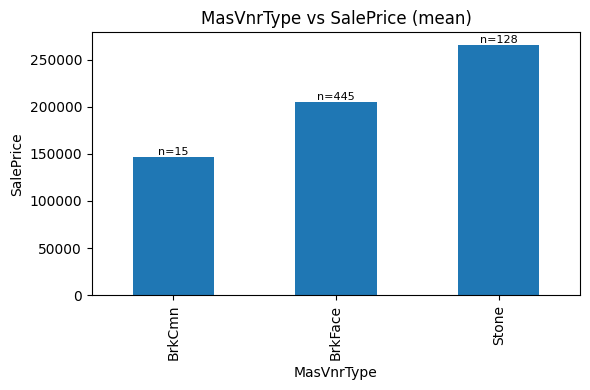

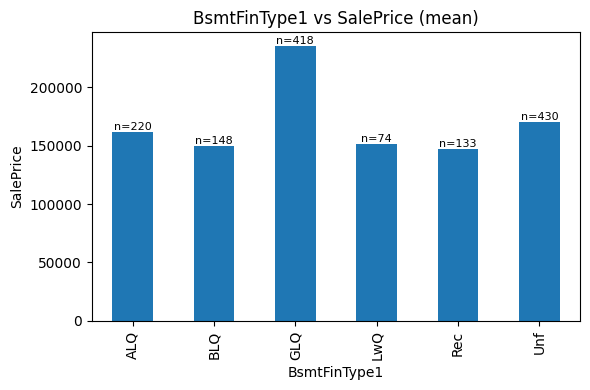

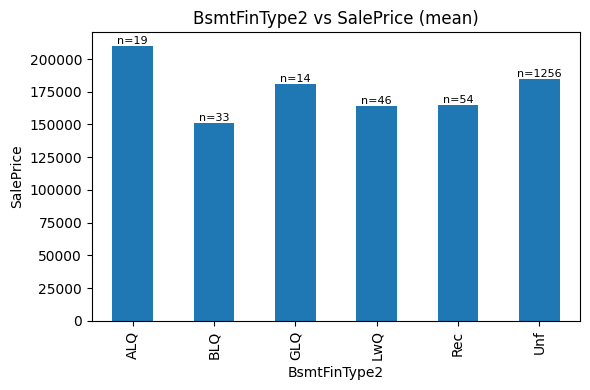

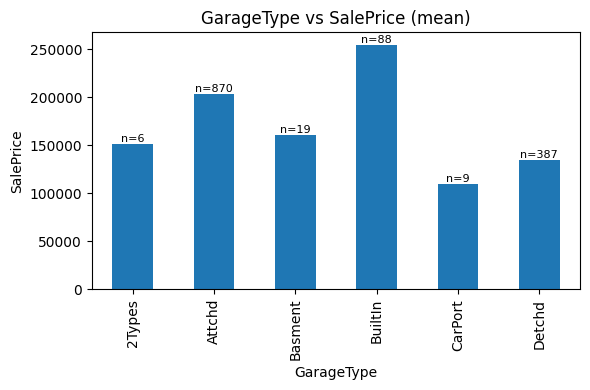

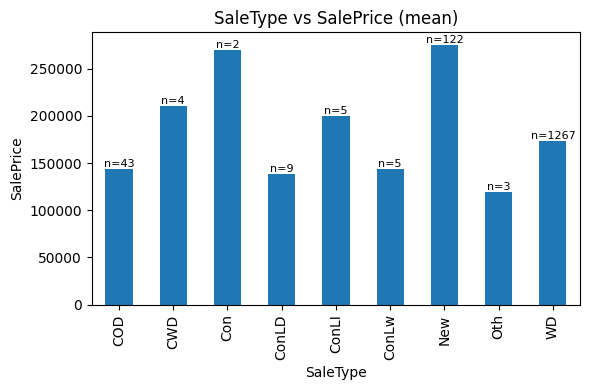

In [92]:
#now lets inspect the type features
for col in type_cols:
    plot_target_by_category(train_eda, col)

In [96]:
#The two bsmt features above are ordinal
nominal_cols += [c for c in type_cols if 'bsmt' not in c.lower()] + ['Condition1', 'Condition2', 'SaleCondition'] 

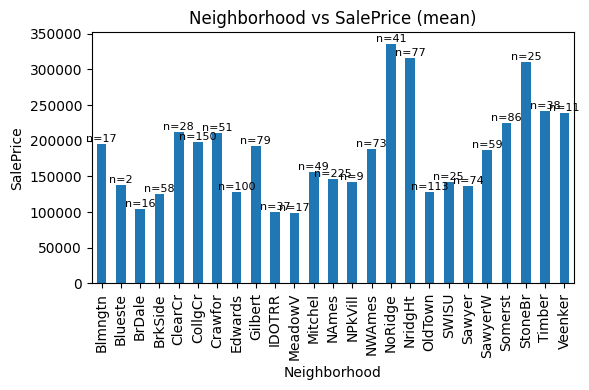

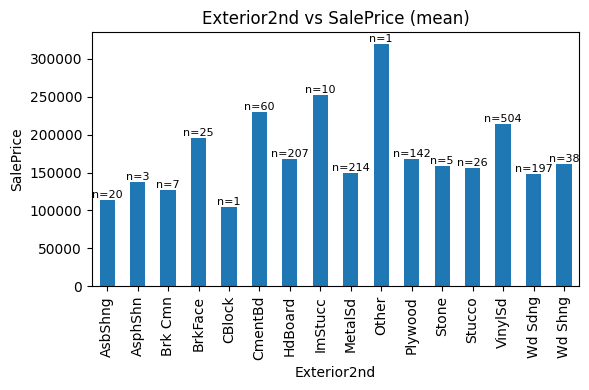

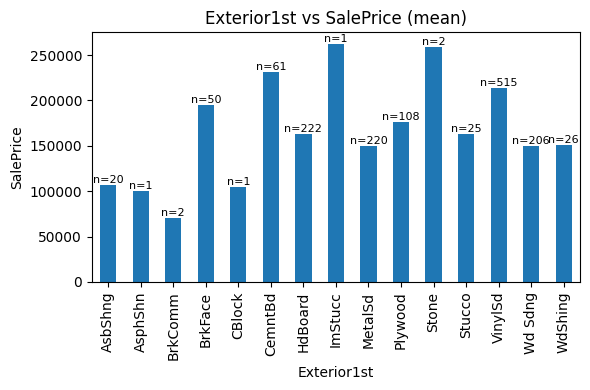

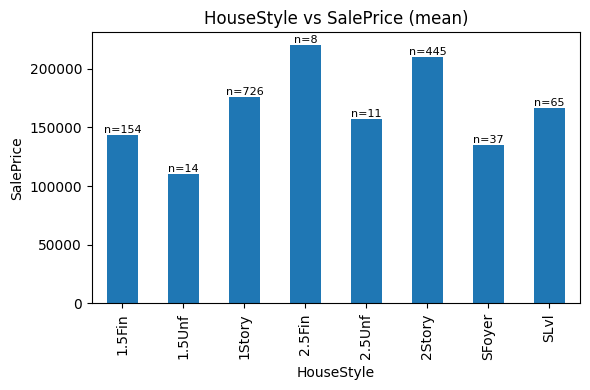

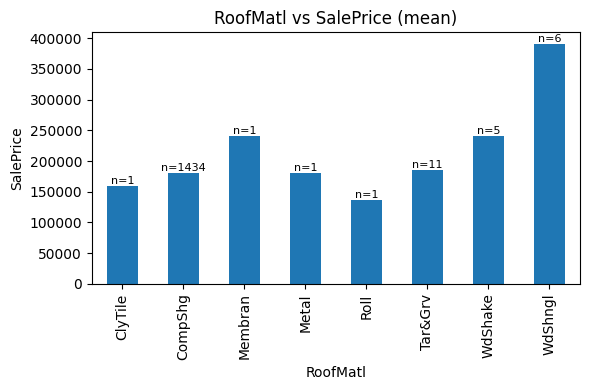

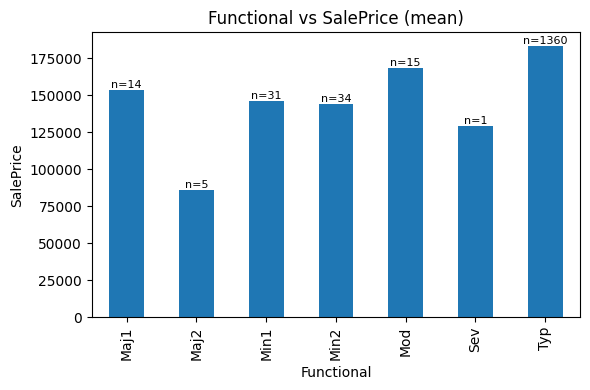

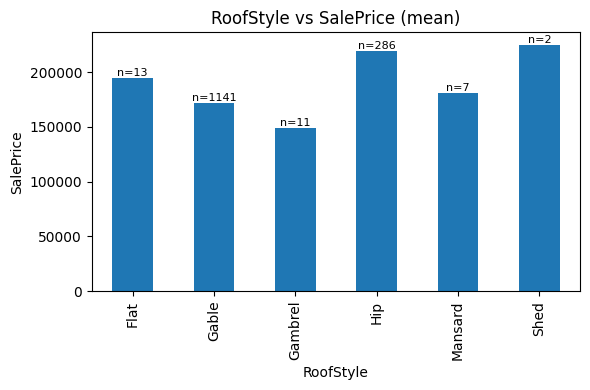

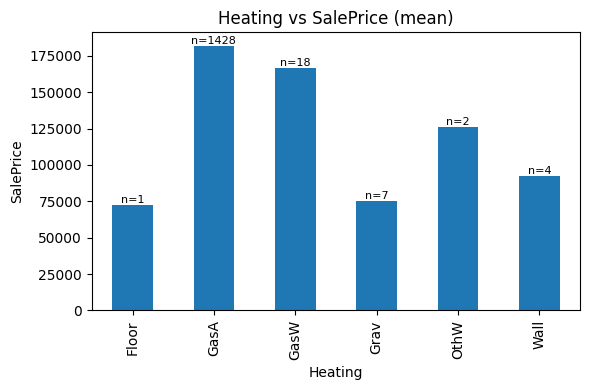

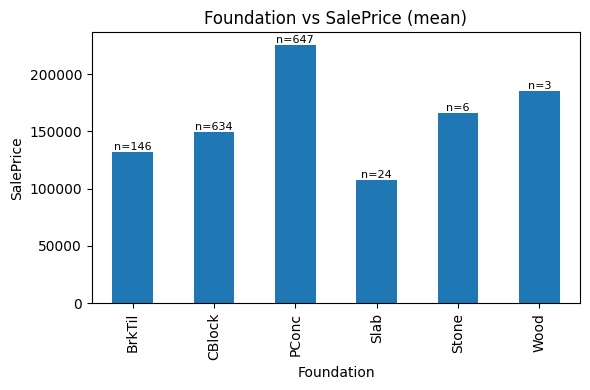

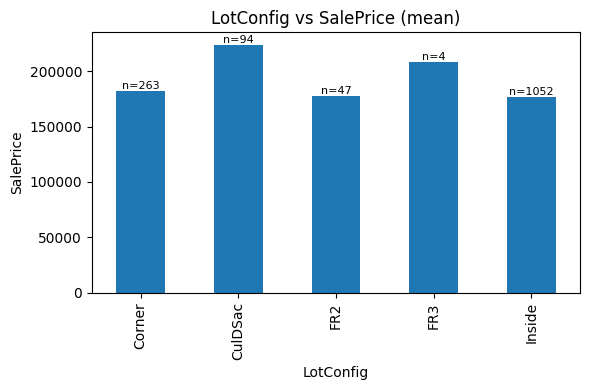

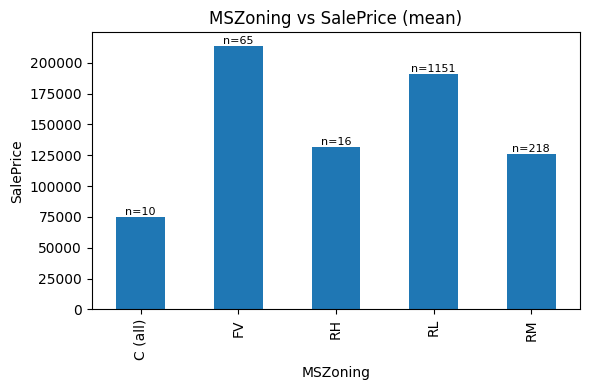

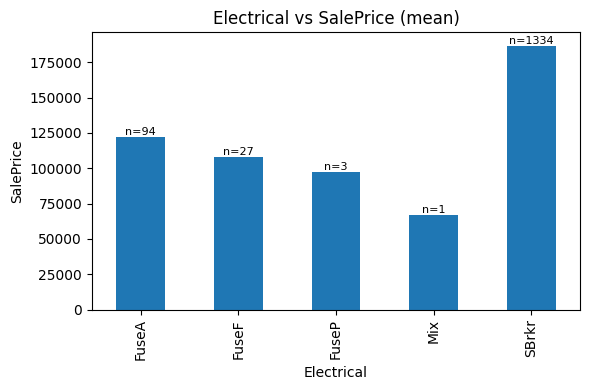

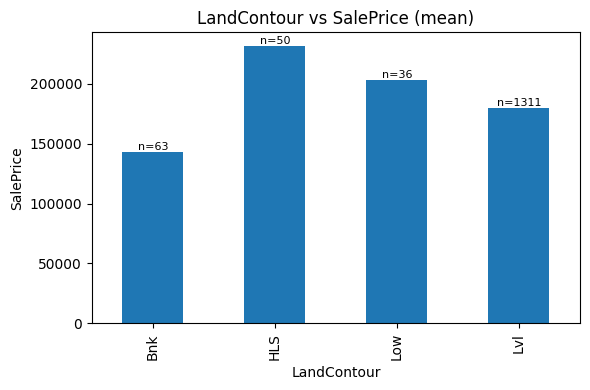

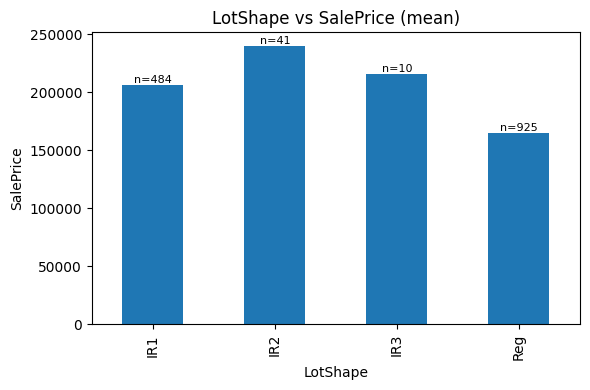

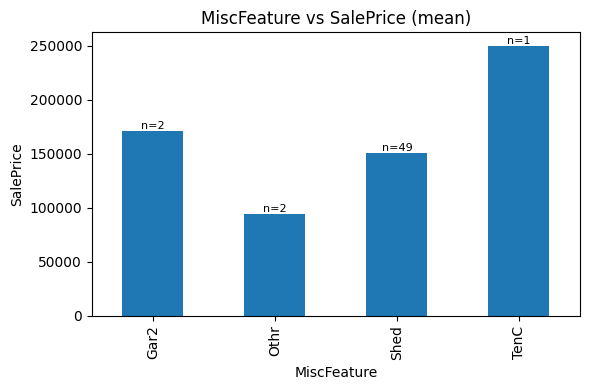

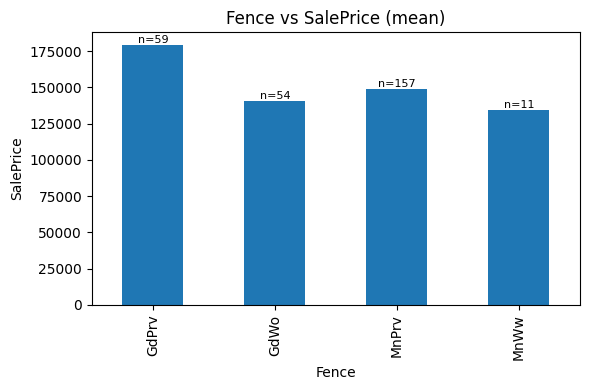

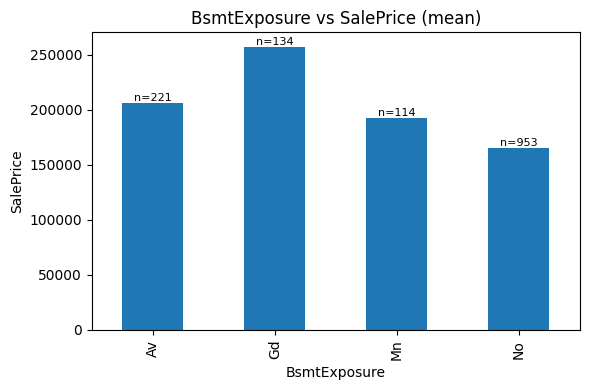

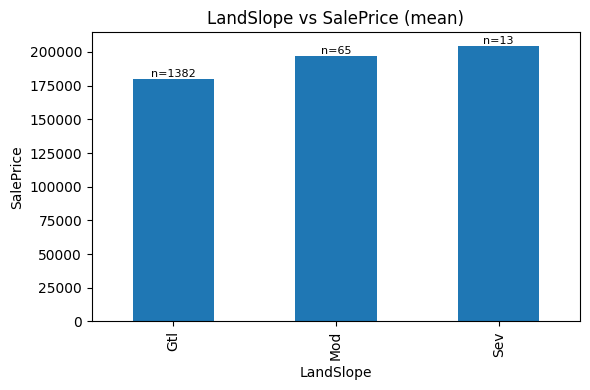

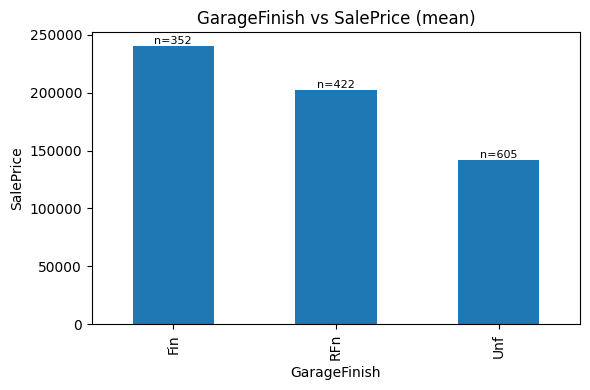

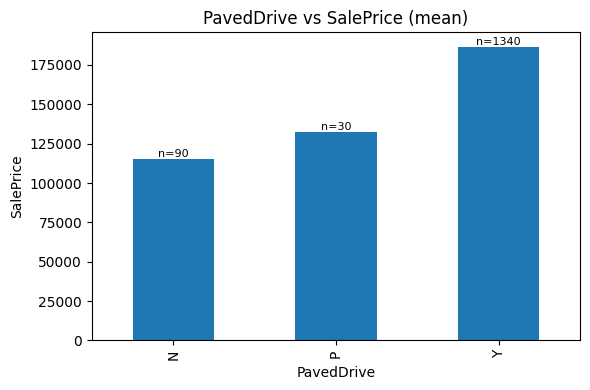

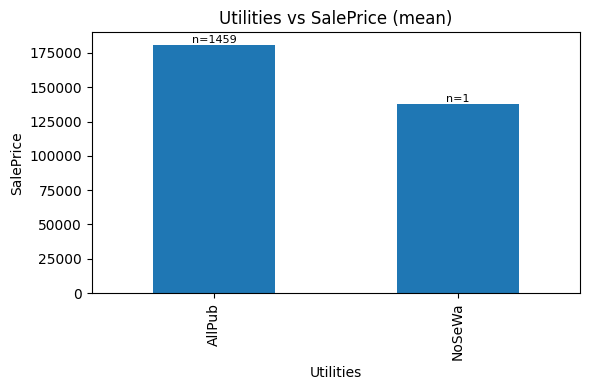

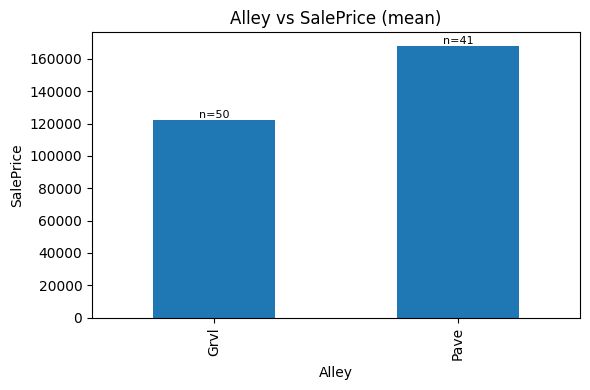

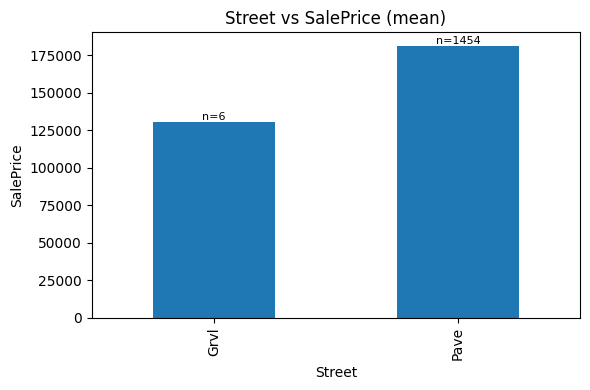

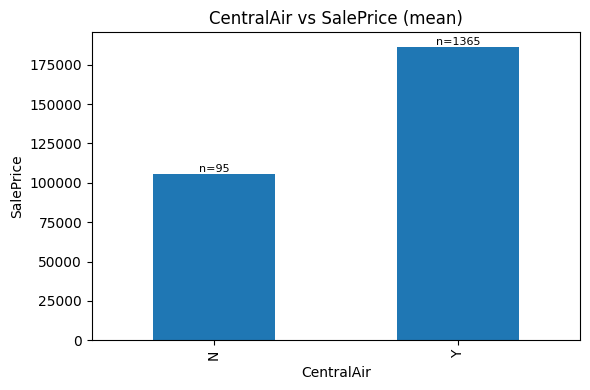

In [95]:
#now the rest of object features
for col in [c for c in obj_audit.index if c not in nominal_cols + qual_cols]:
    plot_target_by_category(train_eda, col)

In [99]:
obj_ordinal_cols = qual_cols + ['Functional', 'LandContour', 'LotShape', 'BsmtExposure', 'LandSlope', 'GarageFinish', 'PavedDrive']
obj_already_binary_cols = ['Street', 'CentralAir']
functional_map = {
    'Typ': 0,
    'Mod': 1,
    'Min1': 2,
    'Min2': 3,
    'Maj1': 4,
    'Maj2': 5,
    'Sev': 5
}
LandContour_map = {
    "Low": 0,
    "HLS": 1,
    "Bnk": 2,
    "Lvl": 3
}
LotShape_map = {
    "IR3": 0,
    "IR2": 1,
    "IR1": 2,
    "Reg": 3
}

bsmtExposure_map = {
    'No': 0,
    'Mn': 1,
    'Av': 2,
    'Gd': 3
}

landSlope_map = {
    'Gtl': 0,
    'Mod': 1,
    'Sev': 2
}

GarageFinish_map = {
    'Unf': 0,
    'RFn': 1,
    'Fin': 2
}

PavedDrive_map = {
    'N': 0,
    'P': 1,
    'Y': 2
}
